In [3]:
import re
import subprocess
from Bio import SeqIO
from Bio.Seq import Seq

In [42]:
blin = 'genes.fasta'
subj = 'genomic.gbff'
newsubj = 'RKQQC_annotated_chr.fa'
failsubj = 'RKQQC_unknown_chr.fa'
blastout = 'RKQQC_blastn.out'

In [76]:
chrom_conv = {}

with open(subj, 'r') as f, open(newsubj, 'w') as fout, open(failsubj, 'w') as fail:
    for record in SeqIO.parse(f, 'genbank'):
        for feature in record.features:
            if 'chromosome' in feature.qualifiers:
                chrom_conv[record.id] = feature.qualifiers['chromosome'][0]
                fout.write(f'>{record.id} - Chromosome: {feature.qualifiers['chromosome'][0]} ({len(record.seq)} bp)\n')
                fout.write(str(record.seq) + '\n')
            elif 'chromosome' not in feature.qualifiers:
                fail.write(f'>{record.id} - Chromosome: Unknown\n')
                fail.write(str(record.seq) + '\n')

In [28]:
subprocess.run(['blastn', '-query', blin, '-subject', newsubj, '-outfmt', '6 qseqid sseqid pident bitscore sstart send sseq', '-out', blastout])

CompletedProcess(args=['blastn', '-query', 'genes.fasta', '-subject', 'RKQQC_annotated_chr.fa', '-outfmt', '6 qseqid sseqid pident bitscore sstart send sseq', '-out', 'RKQQC_blastn.out'], returncode=0)

In [78]:
gene_dict = {}

with open(blastout, 'r') as f:
    for line in f:
        line = line.strip().split('\t')
        gene, chromID, pident, bitscore, sstart, send, sseq = line
        if chromID in chrom_conv:
            chrom = chrom_conv[chromID]
            if (gene not in gene_dict) and (int(float(bitscore)) > 1000) and (float(pident) > 95):
                gene_dict[gene] = chrom, sstart, send

{'PGTG_19919': ('15F', '443906', '442749'), 'PGTG_19587': ('5E', '3252408', '3253761'), 'PGTG_19160': ('6E', '2430569', '2432130'), 'PGTG_18858': ('12E', '1330196', '1331612'), 'PGTG_19012': ('3F', '891688', '889994'), 'PGTG_19043': ('8F', '3474845', '3476231'), 'PGTG_22627': ('2F', '4445126', '4446232'), 'PGTG_22597': ('2F', '1085777', '1087661'), 'PGTG_18583': ('2F', '1107260', '1109261'), 'PGTG_18625': ('15F', '1700674', '1699177'), 'PGTG_18631': ('15F', '1671027', '1669620'), 'PGTG_22615': ('5F', '4490217', '4489094'), 'PGTG_18310': ('1F', '1692503', '1691162'), 'PGTG_18464': ('6E', '893632', '895016'), 'PGTG_17963': ('15E', '2046782', '2045266'), 'PGTG_17781': ('15E', '830915', '829476'), 'PGTG_17351': ('3F', '2690319', '2688741'), 'PGTG_22457': ('3F', '2583850', '2582200'), 'PGTG_17020': ('11E', '3173595', '3171813'), 'PGTG_16374': ('1E', '2517695', '2515703'), 'PGTG_17060': ('1F', '6167196', '6165428'), 'PGTG_17064': ('1F', '6149918', '6148164'), 'PGTG_17070': ('1F', '6125866', 

In [5]:
# %pip install pycirclize
from pycirclize import Circos
from pycirclize.parser import Genbank
gbk = Genbank(subj)

AttributeError: Line2D.set() got an unexpected keyword argument 'axis'

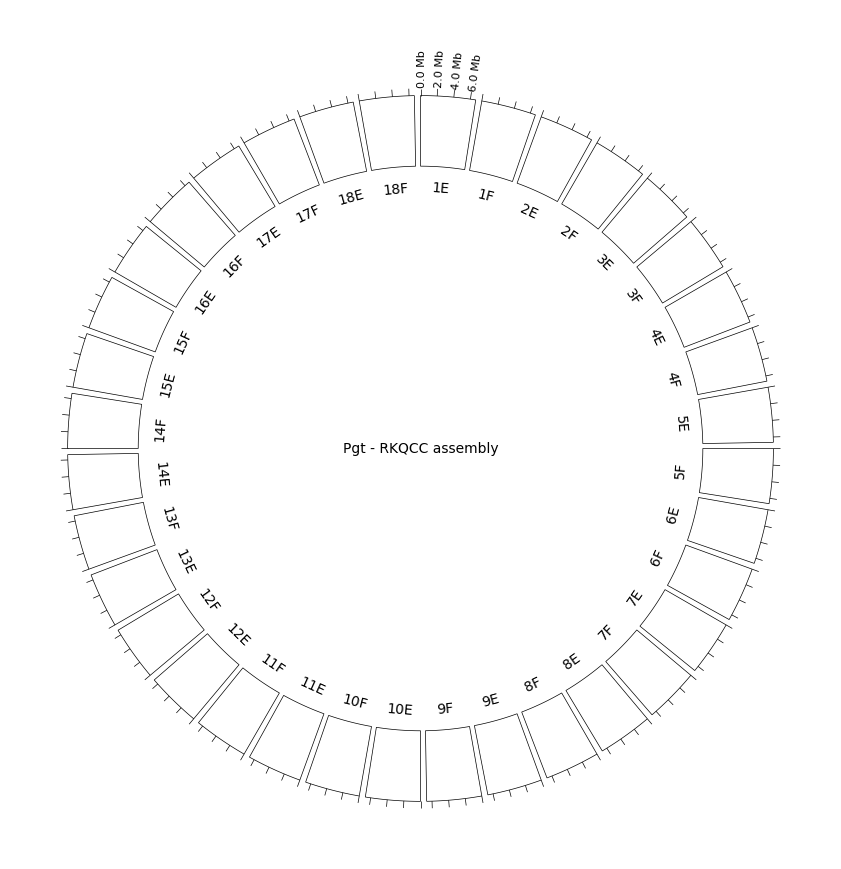

In [79]:
chr_sectors = {feature.qualifiers['chromosome'][0]: gbk.range_size for record in gbk.records for feature in record.features if 'chromosome' in feature.qualifiers}
circos = Circos(sectors=chr_sectors, space=1)
circos.text(f'Pgt - RKQCC assembly')
# circos.rect(r_lim=(90, 100), fc="lightgrey", ec="none", alpha=0.5)
for sector in circos.sectors:
    sector.text(f'{sector.name}', r=72, rotation=45, size=10, ha='center', va='center', color='black')
    track = sector.add_track((80, 100), r_pad_ratio=1)
    track.xticks_by_interval(interval=2000000, label_orientation='vertical', label_formatter=lambda v: f"{v / 1000000:.1f} Mb")
    track.axis()

circos.plotfig()

In [58]:
circos.savefig('RKQQC_circos.png')